In [1]:
%reload_kedro

2023-03-08 19:48:52,814 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-08 19:48:53,082 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-08 19:48:53,288 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-08 19:48:53,289 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
df_portf_metr = catalog.load("portfolio_metrics")
df_portf_pnl = catalog.load("portfolio_pnl")

2023-03-08 19:48:53,791 - kedro.io.data_catalog - INFO - Loading data from `portfolio_metrics` (ParquetDataSet)...
2023-03-08 19:48:53,839 - kedro.io.data_catalog - INFO - Loading data from `portfolio_pnl` (ParquetDataSet)...


In [3]:
df_portf_metr

,annual_sharpe,profit_factor_pct,nominal_profit,annual_sortino,max_drawdown_pct,consecutive_wins,consecutive_losses
0,1.204439,1.202176,28241.61852,1.705155,-0.054896,8,5


<AxesSubplot: title={'center': "Operations' profit over time"}, xlabel='date', ylabel='profit'>

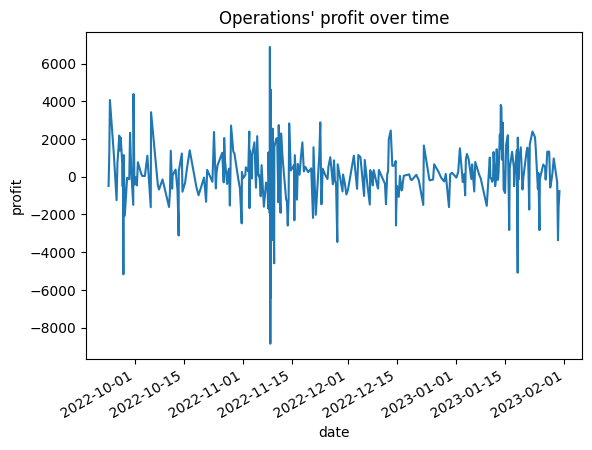

In [8]:
df_portf_pnl[["close_time", "op_full_profit"]].set_index("close_time").sort_index(). \
                plot(title="Operations' profit over time", 
                     legend=None,
                     xlabel="date",
                     ylabel="profit"
                    )